In [18]:
import pandas as pd
import numpy as np
import cv2
import os
import re

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

In [19]:
DIR_INPUT = '../data/global-wheat-detection'
DIR_TRAIN = f'{DIR_INPUT}/train_3'
DIR_TEST = f'{DIR_INPUT}/test'

train_df = pd.read_csv(f'{DIR_INPUT}/train_3.csv')
train_df.shape

(137, 5)

In [20]:
# 构造训练集

train_df['x'] = -1
train_df['y'] = -1
train_df['w'] = -1
train_df['h'] = -1

def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

train_df[['x', 'y', 'w', 'h']] = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x)))
train_df.drop(columns=['bbox'], inplace=True)
train_df['x'] = train_df['x'].astype(np.float64)
train_df['y'] = train_df['y'].astype(np.float64)
train_df['w'] = train_df['w'].astype(np.float64)
train_df['h'] = train_df['h'].astype(np.float64)

train_df

,image_id,width,height,source,x,y,w,h
0,ffc870198,1024,1024,usask_1,447.0,976.0,78.0,48.0
1,ffc870198,1024,1024,usask_1,18.0,141.0,218.0,126.0
2,ffc870198,1024,1024,usask_1,704.0,687.0,79.0,78.0
3,ffc870198,1024,1024,usask_1,943.0,842.0,81.0,143.0
4,ffc870198,1024,1024,usask_1,361.0,222.0,178.0,70.0
...,...,...,...,...,...,...,...,...
132,ffdf83e42,1024,1024,arvalis_1,946.0,419.0,74.0,69.0
133,ffdf83e42,1024,1024,arvalis_1,897.0,647.0,59.0,56.0
134,ffdf83e42,1024,1024,arvalis_1,490.0,912.0,62.0,81.0
135,ffdf83e42,1024,1024,arvalis_1,179.0,343.0,66.0,96.0


In [21]:
# 拆分数据集

image_ids = train_df['image_id'].unique()
valid_ids = image_ids[2:] # 这个拆分的方式似乎可以提升吧，这个过于手动了。
train_ids = image_ids[:2] # 选择20%会比较好呀，注意-2，只是代表1个值
valid_df = train_df[train_df['image_id'].isin(valid_ids)]
train_df = train_df[train_df['image_id'].isin(train_ids)]
train_df.shape , valid_df.shape 

((98, 8), (39, 8))

In [22]:
# 构建Dataset
class WheatDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [23]:
# Albumentations
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [24]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [25]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [26]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = WheatDataset(train_df, DIR_TRAIN, get_train_transform())
valid_dataset = WheatDataset(valid_df, DIR_TRAIN, get_valid_transform())


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=False,
    # num_workers=2, # 用CPU的话，这就会出错 
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=1,
    shuffle=False,
    # num_workers=1, # DataLoader worker (pid(s) 18576) exited unexpectedly
    collate_fn=collate_fn
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


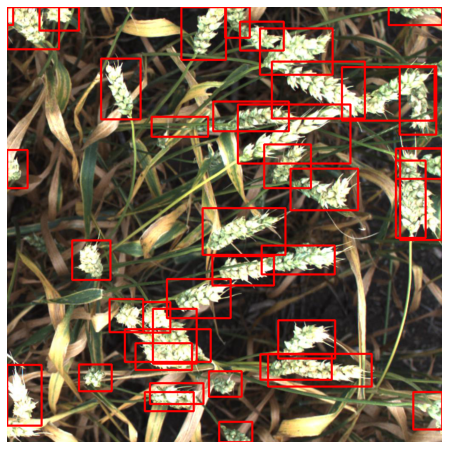

In [27]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

images, targets, image_ids = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
sample = images[0].permute(1,2,0).cpu().numpy()
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

In [28]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None

# 我的20张图片，训练5轮，完全可以用于预测
# 后续测试，一张图片可以不可以。不训练可以不可以，反正也是预训练好了的模型嘛！
# 测试了5次和1次，重新训练5次的效果明显比1次好
# 又试了一下1次都不训练的情况 - 结果显示，一次都不训练，就是随机出100个框框，基本无效果。训1次后又一些效果，2次以上就有明显效果了。-- 这就是迁移学习吧。
num_epochs = 1

In [29]:
loss_hist = Averager() # 考虑简化loss function的设定
itr = 1

for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets, image_ids in train_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        print("Loop", image_ids)
        print(images)
        print(targets)

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}")  

Loop ('ffc870198',)
[tensor([[[0.5020, 0.5098, 0.5255,  ..., 0.1882, 0.1922, 0.2078],
         [0.6196, 0.6275, 0.6431,  ..., 0.1765, 0.1804, 0.1961],
         [0.6941, 0.6980, 0.7059,  ..., 0.1725, 0.1765, 0.1804],
         ...,
         [0.8314, 0.8078, 0.8118,  ..., 0.5686, 0.5725, 0.5961],
         [0.8471, 0.8157, 0.8196,  ..., 0.5020, 0.4980, 0.5137],
         [0.8510, 0.8235, 0.8235,  ..., 0.4784, 0.4667, 0.4745]],

        [[0.3804, 0.3882, 0.4039,  ..., 0.1255, 0.1255, 0.1373],
         [0.4980, 0.5059, 0.5216,  ..., 0.1333, 0.1294, 0.1333],
         [0.5725, 0.5765, 0.5843,  ..., 0.1451, 0.1373, 0.1412],
         ...,
         [0.8784, 0.8549, 0.8588,  ..., 0.5451, 0.5451, 0.5686],
         [0.9216, 0.8902, 0.8824,  ..., 0.4824, 0.4745, 0.4902],
         [0.9451, 0.9059, 0.8980,  ..., 0.4627, 0.4471, 0.4549]],

        [[0.3098, 0.3176, 0.3333,  ..., 0.0627, 0.0627, 0.0824],
         [0.4275, 0.4353, 0.4510,  ..., 0.0627, 0.0667, 0.0824],
         [0.4941, 0.4980, 0.5059,  ..

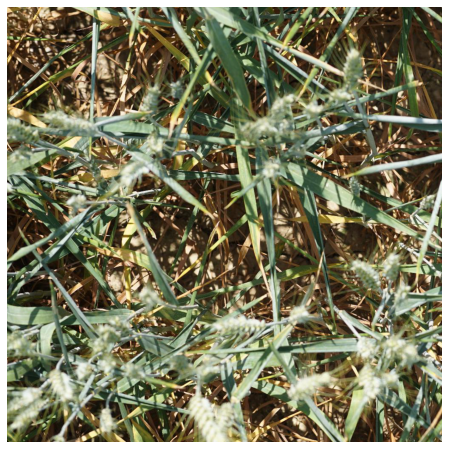

In [30]:
# 只是显示测试图片
images, targets, image_ids = next(iter(valid_data_loader))
images = list(img.to(device) for img in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
boxes_target = targets[0]['boxes'].cpu().numpy().astype(np.int32)
sample = images[0].permute(1,2,0).cpu().numpy()
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.set_axis_off()
ax.imshow(sample)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


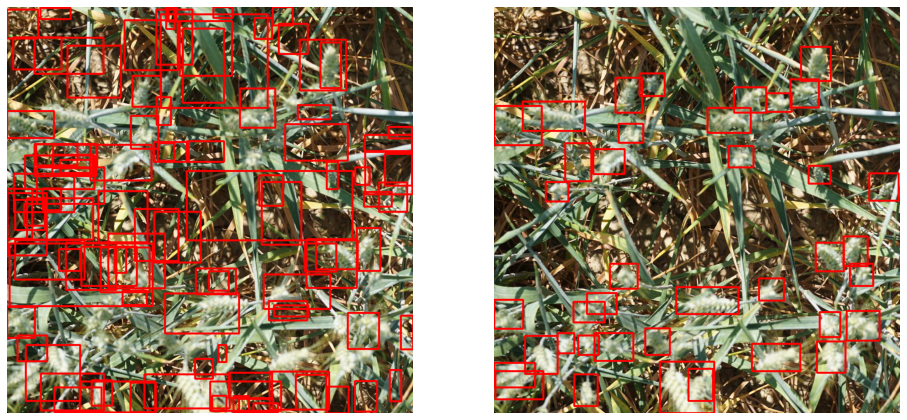

In [31]:
# 并排显示输出结果和选择框的真值
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 8))

images, targets, image_ids = next(iter(valid_data_loader))
images = list(image.to(device) for image in images)
sample = images[0].permute(1,2,0).cpu().numpy()

model.eval()
cpu_device = torch.device("cpu")
outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
boxes_output = outputs[0]['boxes'].cpu().detach().numpy().astype(np.int32)

for box_o in boxes_output:
    cv2.rectangle(sample,
                  (box_o[0], box_o[1]),
                  (box_o[2], box_o[3]),
                  (220, 0, 0), 3)
    
ax1.set_axis_off()
ax1.imshow(sample)

images, targets, image_ids = next(iter(valid_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
boxes_target = targets[0]['boxes'].cpu().numpy().astype(np.int32)
sample = images[0].permute(1,2,0).cpu().numpy()

for box_t in boxes_target:
    cv2.rectangle(sample,
                  (box_t[0], box_t[1]),
                  (box_t[2], box_t[3]),
                  (220, 0, 0), 3)
    
ax2.set_axis_off()
ax2.imshow(sample)

In [32]:
boxes_target.shape, boxes_output.shape

((39, 4), (100, 4))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


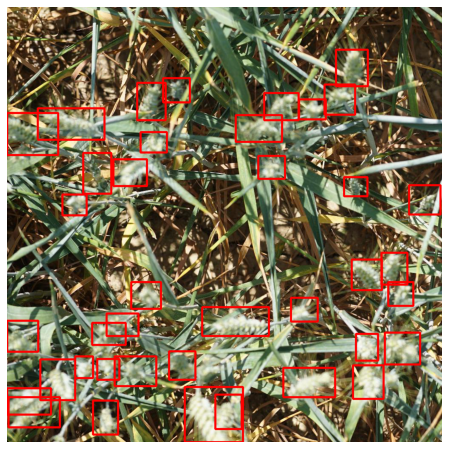

In [33]:
images, targets, image_ids = next(iter(valid_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
sample = images[0].permute(1,2,0).cpu().numpy()
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)